In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    hour = 'y-m-d-hour'
    month = 'month'
    status = 'status'

file_list = os.listdir('../Data/data_per_machine/2022/raw/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C609.csv', '15

In [129]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [130]:
mach_index = 6

In [131]:
df = pd.read_csv('../Data/data_per_machine/2022/raw/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
df[ColumnsOutput.hour] = df[ColumnsInput.time].dt.strftime('%y-%m-%d-%H')
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode  ddc_mch_code ddc_mch_side               ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day   y-m-d-hour
0        7569   9439621671       37886          1306            R     LO_LOADER_IN_PRESS_START 2022-10-10 00:19:01      False     10  22-10-10  22-10-10-00
1        7593   9439621671       37886          1306            R      LO_LOADER_IN_PRESS_STOP 2022-10-10 00:19:04      False     10  22-10-10  22-10-10-00
2        7594   9439621671       37886          1306            R   LO_BLADDER_PRESHAPING_STOP 2022-10-10 00:19:04      False     10  22-10-10  22-10-10-00
3        7595   9439621671       37886          1306            R      LO_BLADDER_VACUUM_START 2022-10-10 00:19:04      False     10  22-10-10  22-10-10-00
4        7596   9439621671       37886          1306            R  LO_BLADDER_PRESHAPING_START 2022-10-10 00:19:04      False     10  22-10-10  22-10-10-00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363546 entries

In [132]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(54, 4)
    y-m-day                 min                 max  work_time
0  22-10-10 2022-10-10 00:19:01 2022-10-10 23:52:10    84789.0
1  22-10-11 2022-10-11 00:03:51 2022-10-11 20:33:12    73761.0
2  22-10-12 2022-10-12 02:25:42 2022-10-12 23:58:59    77597.0
3  22-10-13 2022-10-13 00:03:32 2022-10-13 23:59:30    86158.0
4  22-10-14 2022-10-14 00:05:53 2022-10-14 23:49:54    85441.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-10            L 2022-10-10 05:04:58 2022-10-10 23:52:10    67632.0
1  22-10-10            R 2022-10-10 00:19:01 2022-10-10 23:48:25    84564.0
2  22-10-11            L 2022-10-11 00:07:45 2022-10-11 20:28:44    73259.0
3  22-10-11            R 2022-10-11 00:03:51 2022-10-11 20:33:12    73761.0
4  22-10-12            L 2022-10-12 02:26:59 2022-10-12 23:58:59    77520.0


(51, 5)

In [133]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(54, 2)
(104, 3)


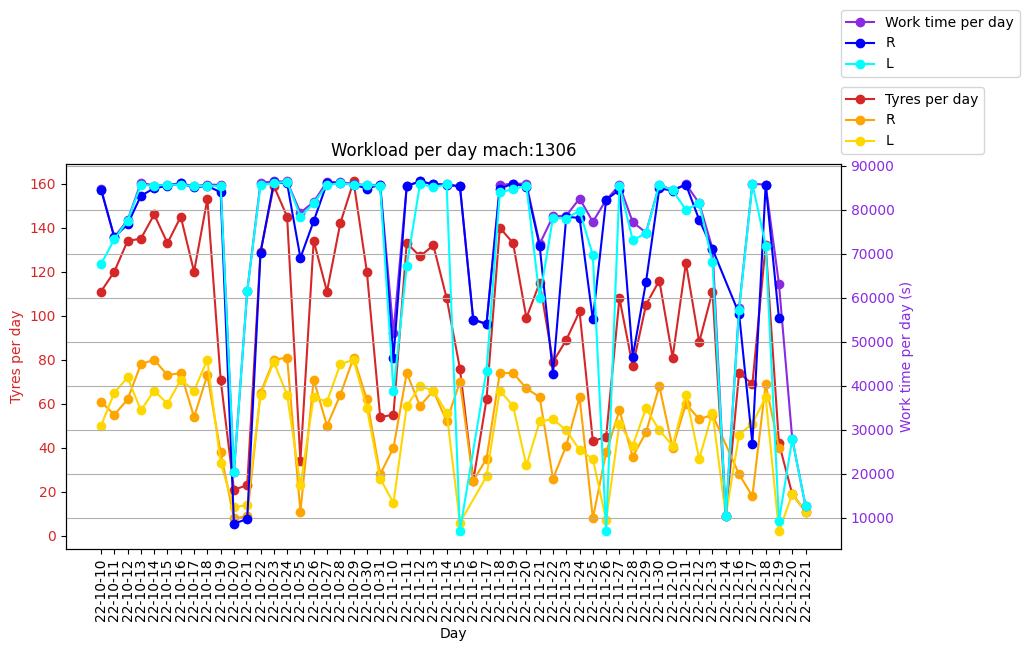

In [134]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title(f'Workload per day mach:{current_machine}')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

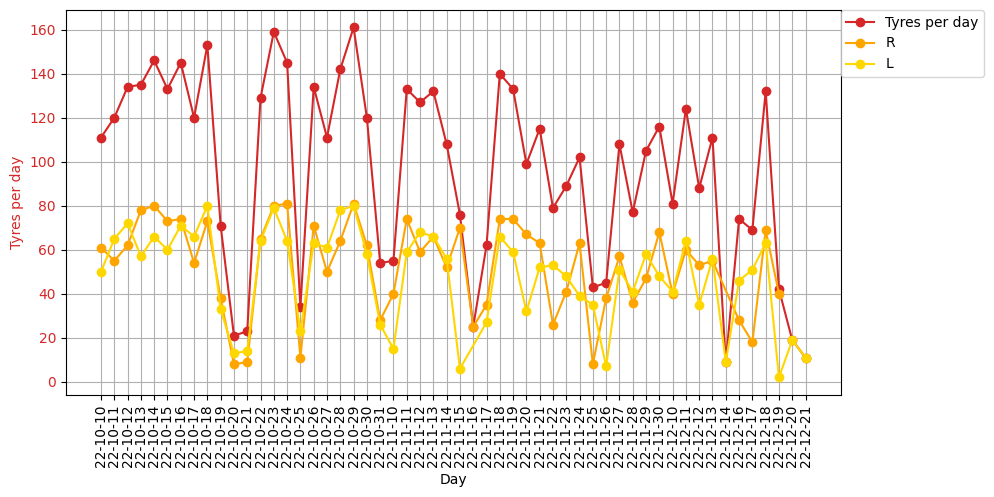

In [135]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

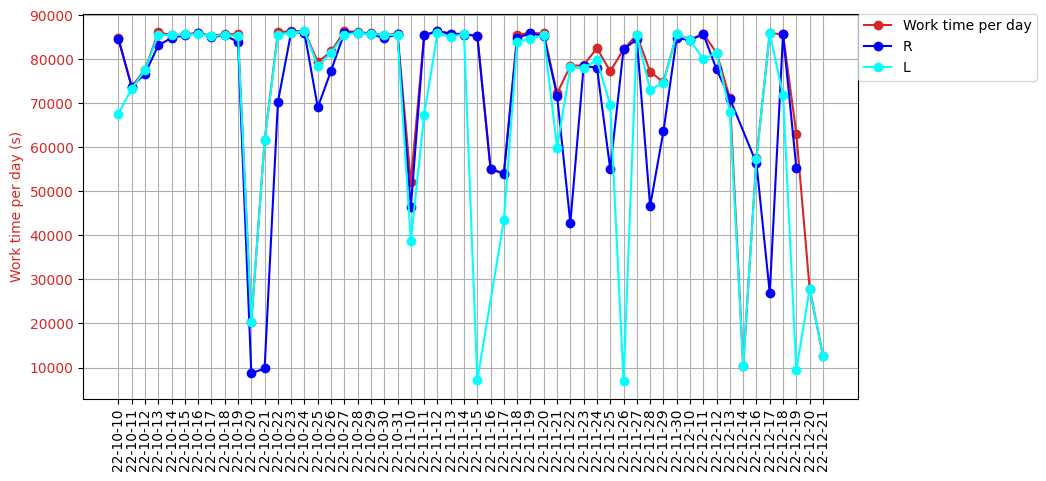

In [136]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [137]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [138]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()
label_for_check_time_loss = label_cycle_status_

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

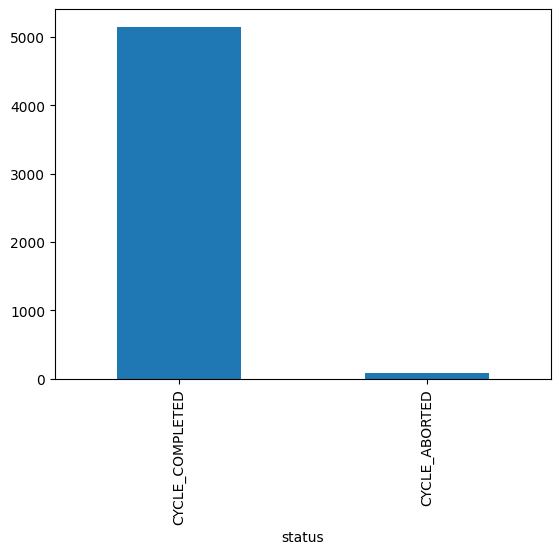

In [139]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

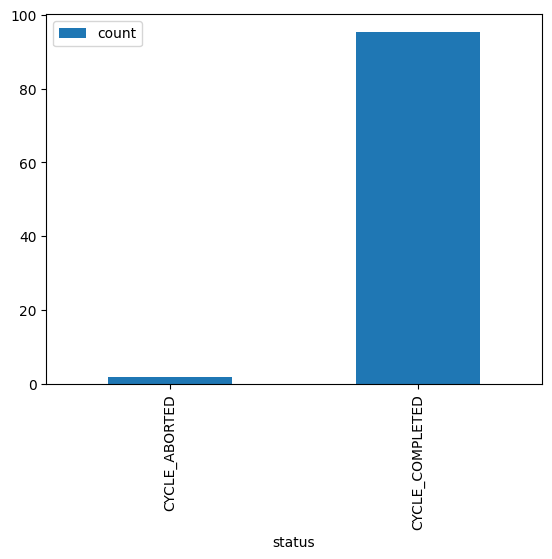

In [140]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [141]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day[status] = 0
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

CYCLE_NOT_STARTED not in columns
54
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-10              2              109                  0
1       22-10-11              1              119                  0
2       22-10-12              0              134                  0
3       22-10-13              2              133                  0
4       22-10-14              4              142                  0
(54, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(54, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(54, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


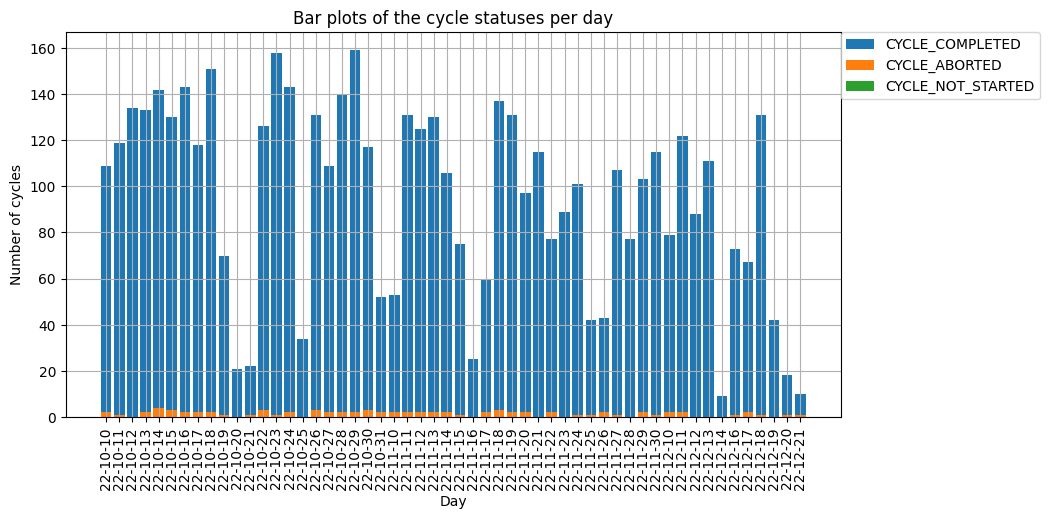

In [142]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [143]:
# label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
# label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
# cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_left = []
# for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
#     statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_left:
#     print(i.shape)
#     print('\n')
# cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_right = []
# for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
#     statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_right:
#     print(i.shape)
#     print('\n')


# cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
# cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
# cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
# for status in status_names:
#     if status not in cycle_statuses_per_day_left.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_left[status] = 0
#     if status not in cycle_statuses_per_day_right.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_right[status] = 0
# print(cycle_statuses_per_day_right)




In [144]:
cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day_left.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_left[status] = 0
    if status not in cycle_statuses_per_day_right.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_right[status] = 0
statuses_per_day_left = []
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_left:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')
statuses_per_day_right = []    
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_right:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

CYCLE_NOT_STARTED not in columns
CYCLE_NOT_STARTED not in columns
(53, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(53, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(53, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(51, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(51, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status'

3


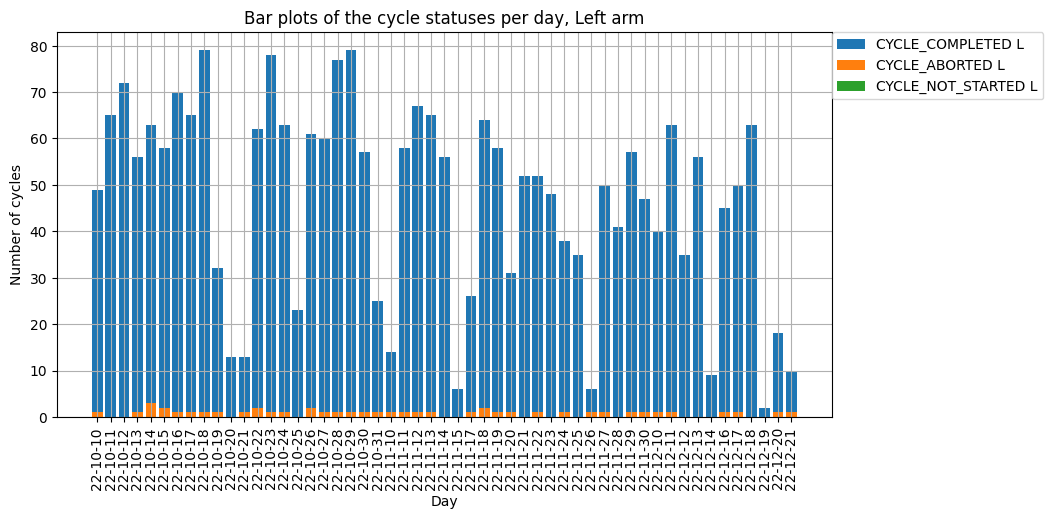

In [145]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

54


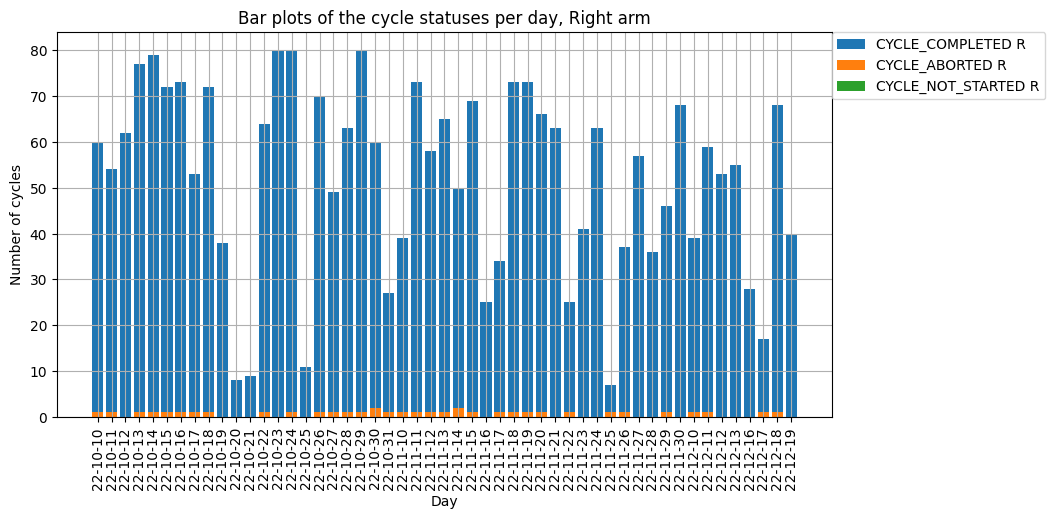

In [146]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [147]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

Index(['y-m-day', 'ddc_ev_timestamp', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')
    y-m-day    ddc_ev_timestamp ddc_mch_side  ddc_barcode                     first                         last             status
0  22-10-10 2022-10-10 00:19:01            R   9439621671  LO_LOADER_IN_PRESS_START     LO_LOADER_IN_PRESS_START      CYCLE_ABORTED
1  22-10-10 2022-10-10 00:19:04            R   9439621671   LO_LOADER_IN_PRESS_STOP  LO_BLADDER_PRESHAPING_START  CYCLE_NOT_STARTED
2  22-10-10 2022-10-10 00:19:10            R   9439621671    LO_BLADDER_VACUUM_STOP         LO_LOADER_DOWN_START  CYCLE_NOT_STARTED
3  22-10-10 2022-10-10 00:19:16            R   9439621671       LO_LOADER_DOWN_STOP            LO_TCR_DOWN_START  CYCLE_NOT_STARTED
4  22-10-10 2022-10-10 00:19:18            R   9439621671          LO_TCR_DOWN_STOP          LO_PRESHAPING_START  CYCLE_NOT_STARTED


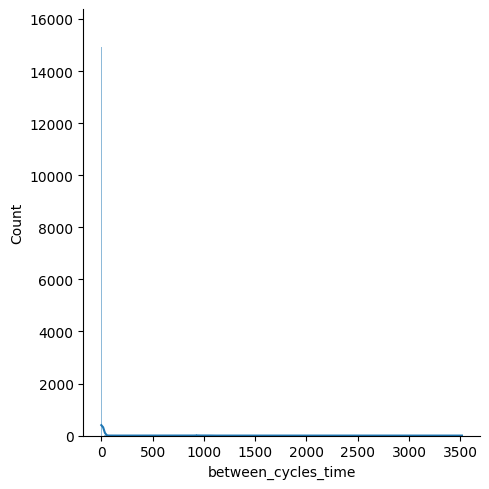

In [148]:
label_cycle_status_for_time = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.time, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status_for_time[ColumnsOutput.status] = False
print(label_cycle_status_for_time.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status_for_time[ColumnsOutput.status] = label_cycle_status_for_time.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status_for_time.value_counts(ColumnsOutput.status)
print(label_cycle_status_for_time.head())
plt.show()

label_cycle_status_for_time_left = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'L']
label_cycle_status_for_time_right = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'R']

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left[ColumnsInput.time].diff().dt.total_seconds()
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right[ColumnsInput.time].diff().dt.total_seconds()

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left['between_cycles_time'].fillna(0)
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right['between_cycles_time'].fillna(0)

z = np.abs(stats.zscore(label_cycle_status_for_time_right['between_cycles_time']))
label_cycle_status_for_time_right = label_cycle_status_for_time_right[(z < 1)]

z = np.abs(stats.zscore(label_cycle_status_for_time_left['between_cycles_time']))
label_cycle_status_for_time_left = label_cycle_status_for_time_left[(z < 1)]

sns.displot(label_cycle_status_for_time_right['between_cycles_time'], kde=True)
plt.show()

# label_cycle_status_for_time_right_stats = label_cycle_status_for_time_right.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
# label_cycle_status_for_time_left_stats = label_cycle_status_for_time_left.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# print(label_cycle_status_for_time_right_stats)
# label_cycle_status_for_time_left_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')
# print(label_cycle_status_for_time_left_stats)
# label_cycle_status_for_time_right_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')



## Getting all previous indices per day fro the machines

In [149]:

len(days)



54

In [150]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-10,111,50.0,61.0,84789.0,67632.0,84564.0,49.0,1.0,0.0,60.0,1.0,0.0,109,2,0
1,22-10-11,120,65.0,55.0,73761.0,73259.0,73761.0,65.0,0.0,0.0,54.0,1.0,0.0,119,1,0
2,22-10-12,134,72.0,62.0,77597.0,77520.0,76670.0,72.0,0.0,0.0,62.0,0.0,0.0,134,0,0
3,22-10-13,135,57.0,78.0,86158.0,85604.0,83139.0,56.0,1.0,0.0,77.0,1.0,0.0,133,2,0
4,22-10-14,146,66.0,80.0,85441.0,85441.0,84857.0,63.0,3.0,0.0,79.0,1.0,0.0,142,4,0
5,22-10-15,133,60.0,73.0,85670.0,85616.0,85429.0,58.0,2.0,0.0,72.0,1.0,0.0,130,3,0
6,22-10-16,145,71.0,74.0,85962.0,85698.0,85944.0,70.0,1.0,0.0,73.0,1.0,0.0,143,2,0
7,22-10-17,120,66.0,54.0,85313.0,85301.0,85062.0,65.0,1.0,0.0,53.0,1.0,0.0,118,2,0
8,22-10-18,153,80.0,73.0,85699.0,85444.0,85398.0,79.0,1.0,0.0,72.0,1.0,0.0,151,2,0
9,22-10-19,71,33.0,38.0,85620.0,85307.0,83933.0,32.0,1.0,0.0,38.0,0.0,0.0,70,1,0


<Axes: >

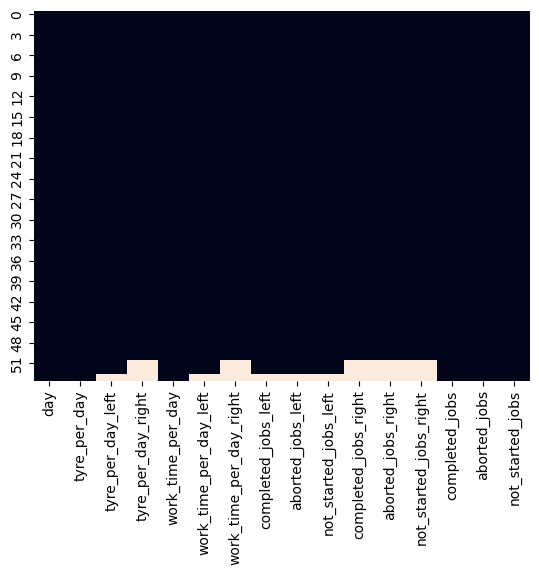

In [151]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

In [152]:
mach_processed_df = mach_processed_df.fillna(0)

### Correlation between the tyres produced and the completed cycles

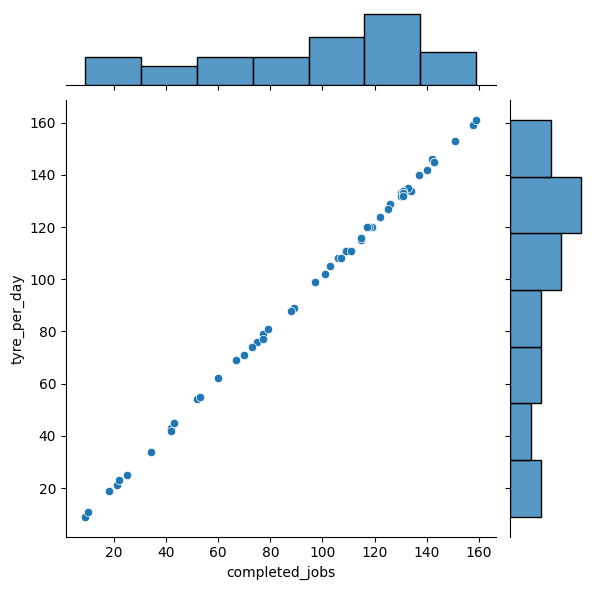

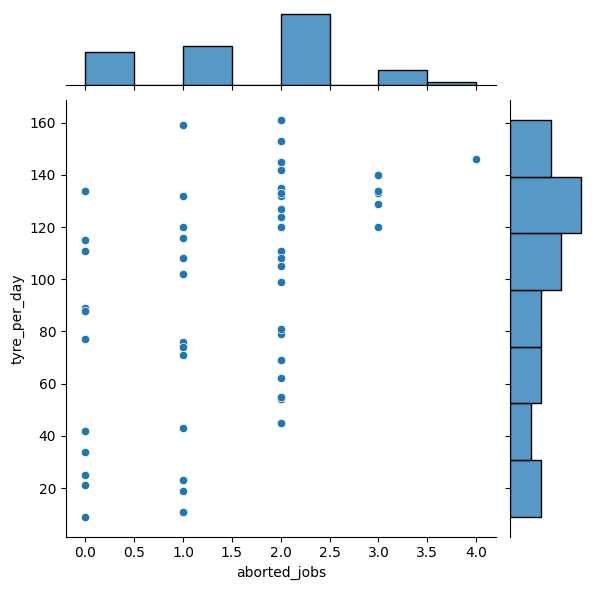

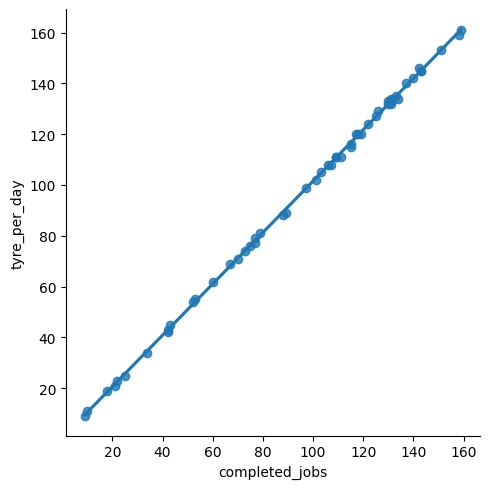

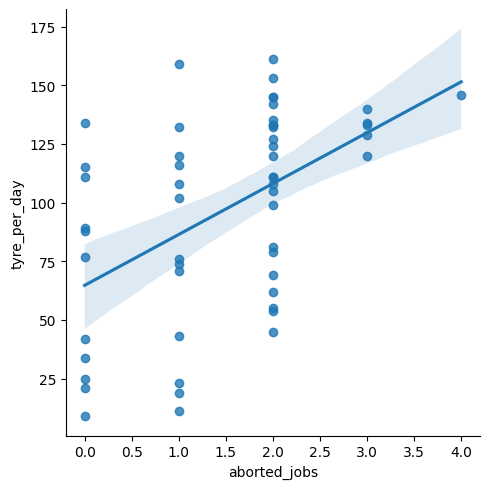

In [153]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

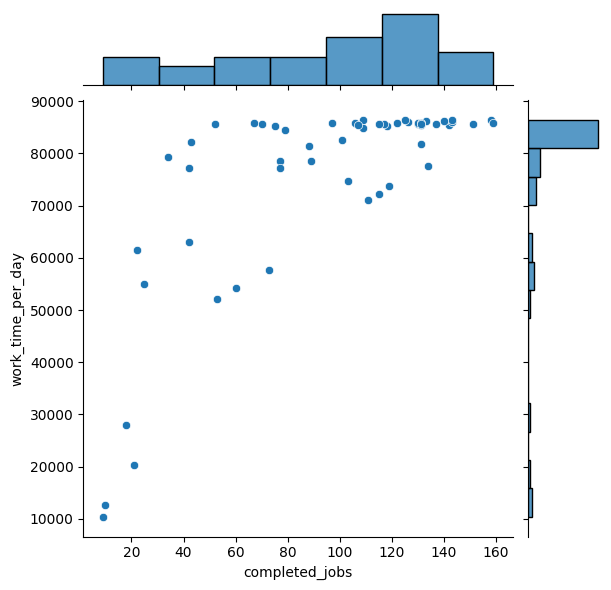

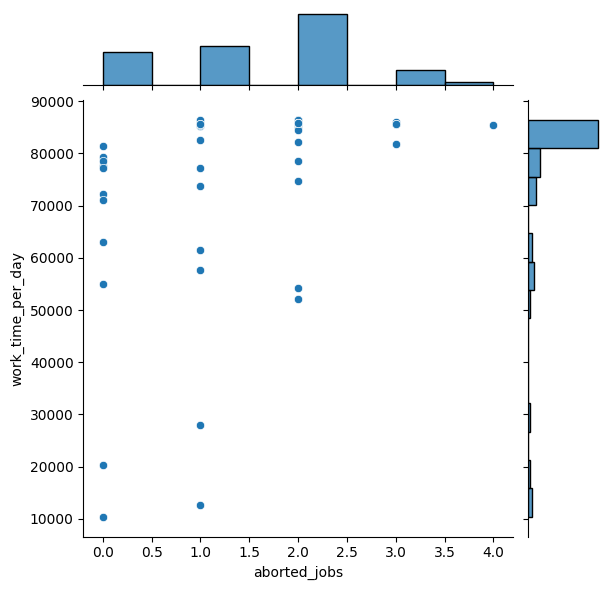

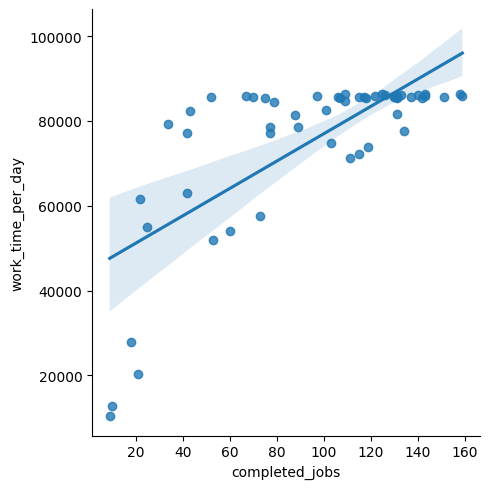

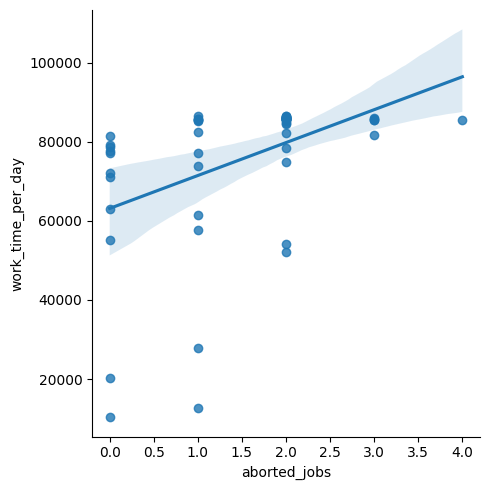

In [154]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

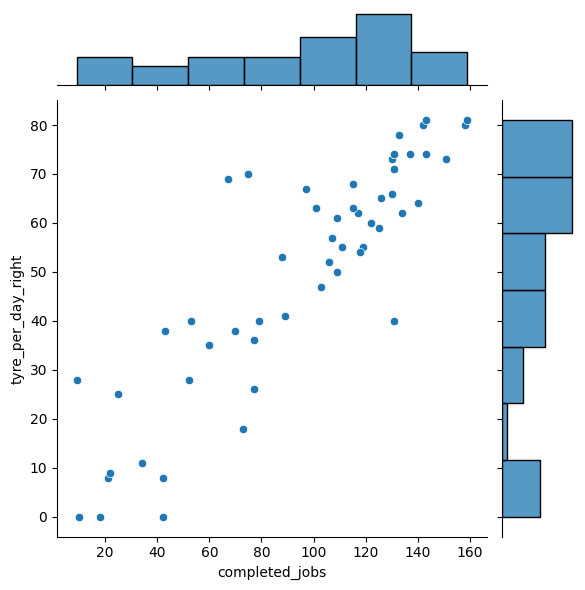

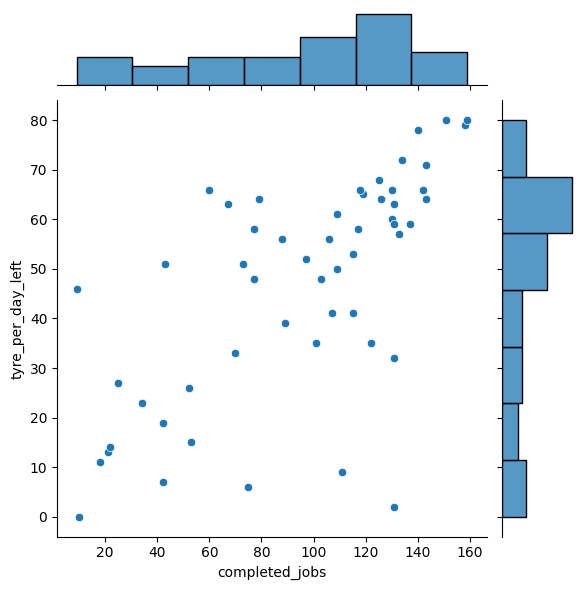

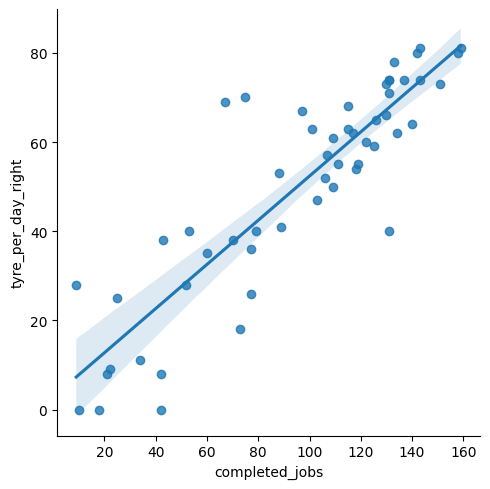

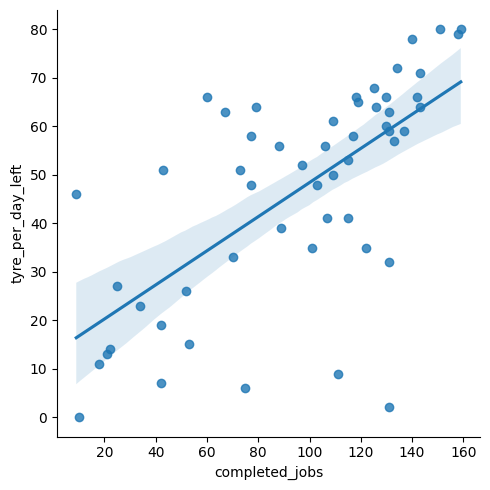

In [155]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

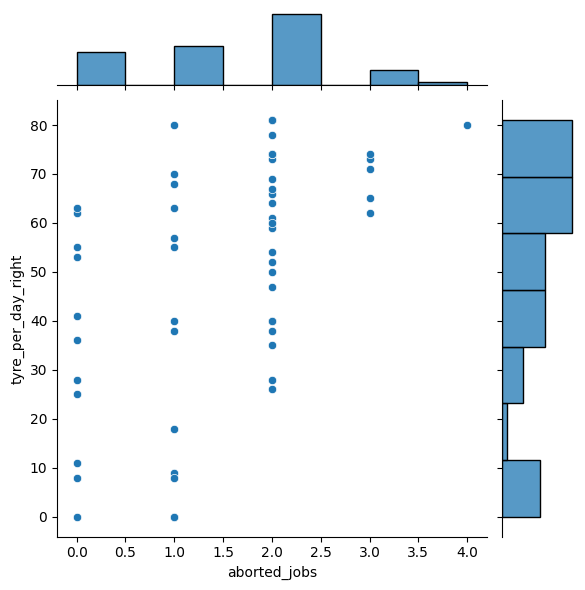

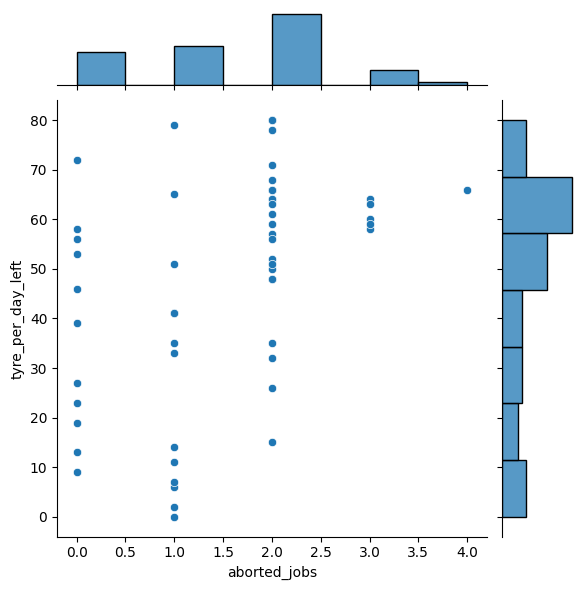

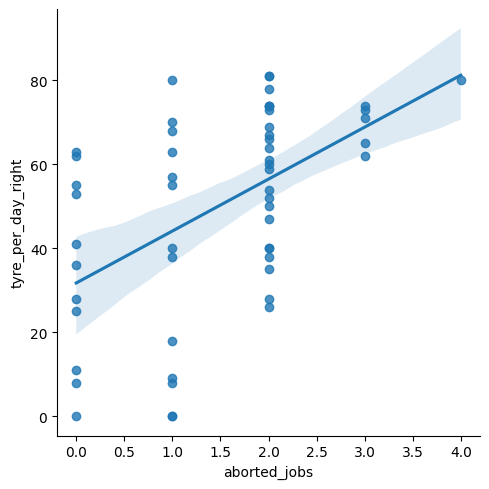

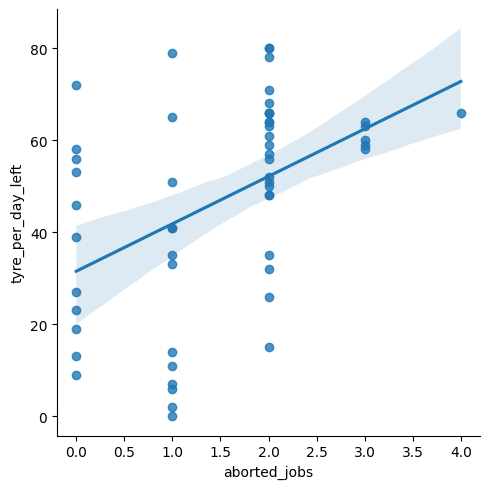

In [156]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


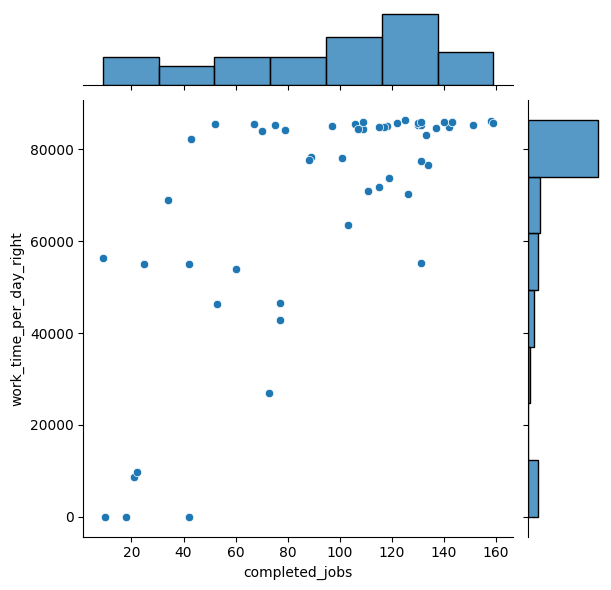

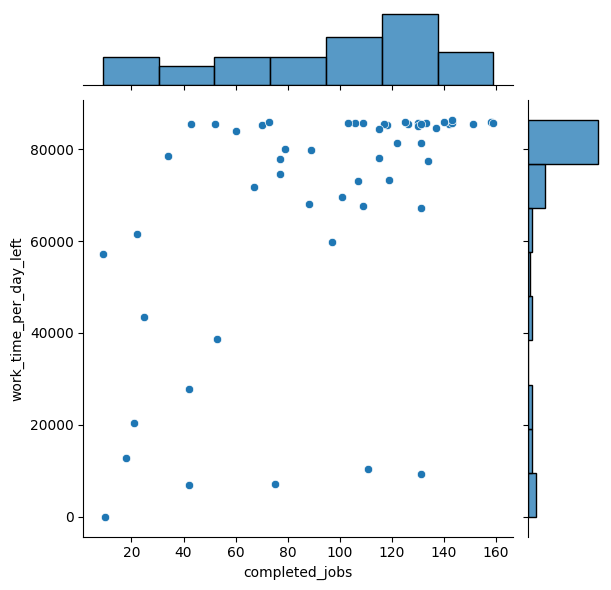

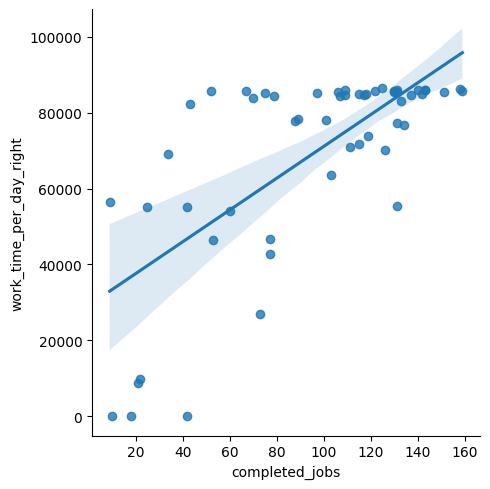

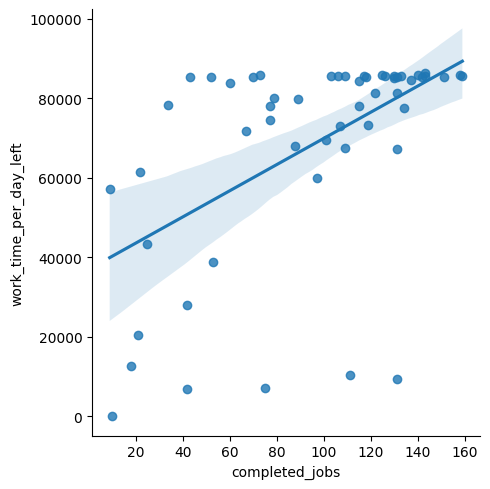

In [157]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

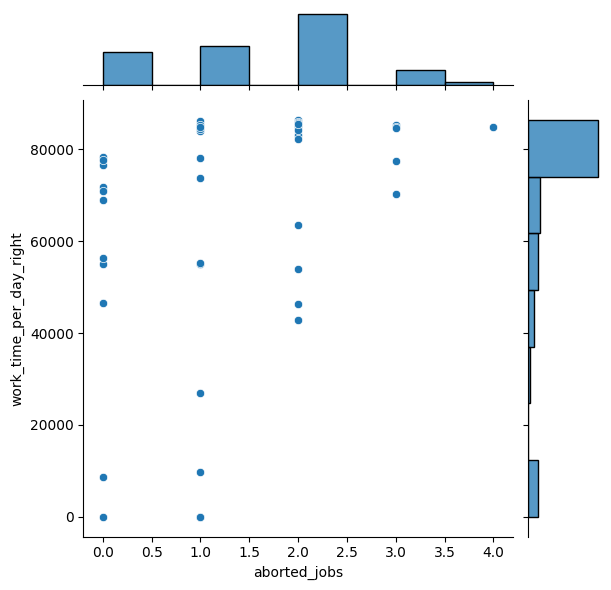

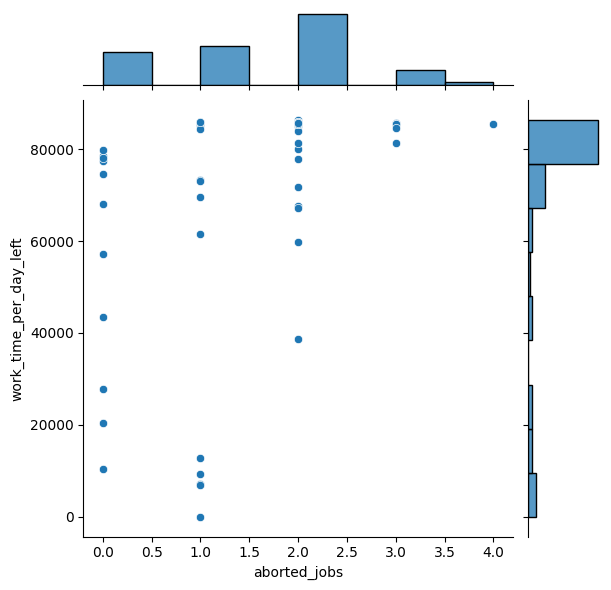

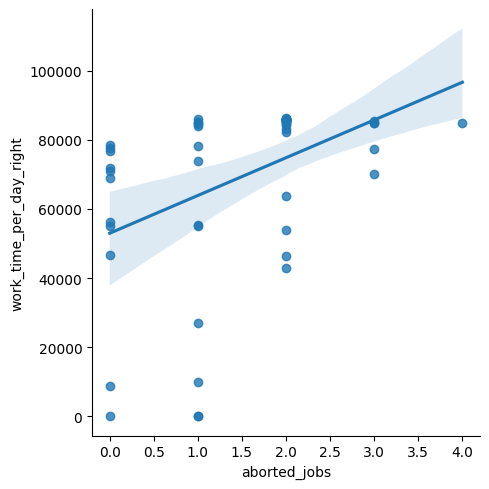

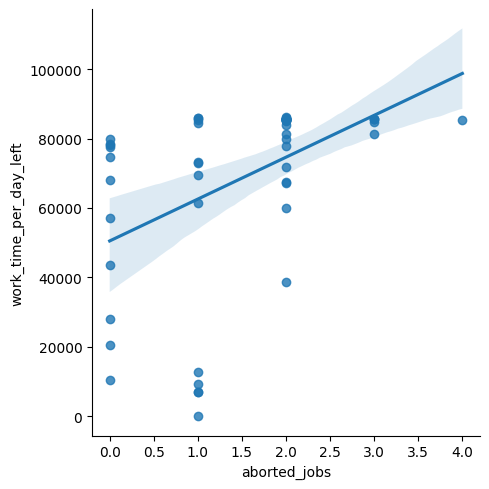

In [158]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)

#### Ideally it should be better to check by arm instead of the enitire miachine at the moment, and apply a regression method to understand the correlation between the barcode processed and the completed cycles

#### fist check the right side

In [159]:
# the data that are more correlated are the tyre per day and the completed jobs.
print(mach_processed_df.columns)

check_corr = mach_processed_df.drop(['day'], axis=1).corr()
check_corr

Index(['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right', 'completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs'], dtype='object')


,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
tyre_per_day,1.000000,0.664989,0.883295,0.723204,0.537777,0.702886,0.665690,0.206402,NaN,0.882292,0.389592,NaN,0.999796,0.499357,NaN
tyre_per_day_left,0.664989,1.000000,0.655642,0.469412,0.805421,0.586681,0.999633,0.359374,NaN,0.651487,0.435380,NaN,0.662058,0.452034,NaN
tyre_per_day_right,0.883295,0.655642,1.000000,0.677272,0.532349,0.826722,0.656654,0.192488,NaN,0.999772,0.402157,NaN,0.881436,0.513163,NaN
work_time_per_day,0.723204,0.469412,0.677272,1.000000,0.558835,0.789042,0.471627,0.086492,NaN,0.673744,0.417005,NaN,0.721374,0.433337,NaN
work_time_per_day_left,0.537777,0.805421,0.532349,0.558835,1.000000,0.612273,0.802922,0.365280,NaN,0.527901,0.399530,NaN,0.533324,0.454975,NaN
work_time_per_day_right,0.702886,0.586681,0.826722,0.789042,0.612273,1.000000,0.589796,0.096160,NaN,0.824111,0.436296,NaN,0.700999,0.425818,NaN
completed_jobs_left,0.665690,0.999633,0.656654,0.471627,0.802922,0.589796,1.000000,0.333946,NaN,0.652574,0.432564,NaN,0.663019,0.441262,NaN
aborted_jobs_left,0.206402,0.359374,0.192488,0.086492,0.365280,0.096160,0.333946,1.000000,NaN,0.188467,0.247901,NaN,0.196468,0.527578,NaN
not_started_jobs_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
completed_jobs_right,0.882292,0.651487,0.999772,0.673744,0.527901,0.824111,0.652574,0.188467,NaN,1.000000,0.382509,NaN,0.880741,0.499435,NaN


In [160]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def svr_regression(x,y):
    print("Model: SVR")
    model = SVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model 

def grad_boost(x, y):
    print("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
    X_test = scaler.fit_transform(X_test.values.reshape(-1,1))
    y_test = scaler.fit_transform(y_test.values.reshape(-1,1))
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    return model

In [161]:
#split data into train and test
from sklearn.model_selection import train_test_split


right_x = mach_processed_df['tyre_per_day_right']
right_y = mach_processed_df['completed_jobs_right']



left_x = mach_processed_df['tyre_per_day_left']
left_y = mach_processed_df['completed_jobs_left']



model = evaluations(right_x, right_y, lin_regr)
model = evaluations(right_x, right_y, svr_regression)
model = evaluations(right_x, right_y, grad_boost)

model = evaluations(left_x, left_y, lin_regr)
model = evaluations(left_x, left_y, svr_regression)
model = evaluations(left_x, left_y, grad_boost)



Model: Linear Regression
Model score: 0.9994946017125556
Metrics are:
 Accuracy: 0.999408612377997
 MSE: 0.0006844243088842355 
 R2: 0.999408612377997


Model: SVR
Model score: 0.9579777432569219
Metrics are:
 Accuracy: 0.7717209934511946
 MSE: 0.26419170012519494 
 R2: 0.7717209934511946


Model: Gradient Boosting
Model score: 0.9997582928680716
Metrics are:
 Accuracy: 0.9545030246583408
 MSE: 0.05265452766677077 
 R2: 0.9545030246583408


Model: Linear Regression
Model score: 0.9994998070843121
Metrics are:
 Accuracy: 0.9855771728919052
 MSE: 0.03525192786502994 
 R2: 0.9855771728919052


Model: SVR
Model score: 0.9592965948578137
Metrics are:
 Accuracy: 0.2003154994426687
 MSE: 1.9545696635722445 
 R2: 0.2003154994426687


Model: Gradient Boosting
Model score: 0.999933158988147
Metrics are:
 Accuracy: 0.6400471971776185
 MSE: 0.879788001673279 
 R2: 0.6400471971776185




### On entire machine


In [162]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['completed_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.9995588532352458
Metrics are:
 Accuracy: 0.9989783840644486
 MSE: 0.00038961508815347676 
 R2: 0.9989783840644486


Model: SVR
Model score: 0.9667830327361663
Metrics are:
 Accuracy: 0.9081697978711125
 MSE: 0.035021411718962565 
 R2: 0.9081697978711125


Model: Gradient Boosting
Model score: 0.9998567130844342
Metrics are:
 Accuracy: 0.9836443743801052
 MSE: 0.00623756765722463 
 R2: 0.9836443743801052




### evaluate the correlation between the aborted jobs and the tyre produced

In [163]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['aborted_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.20400820388350738
Metrics are:
 Accuracy: 0.17923846640115948
 MSE: 0.482800902116965 
 R2: 0.17923846640115948


Model: SVR
Model score: 0.3441276097126774
Metrics are:
 Accuracy: -0.05288473880723532
 MSE: 0.6193439640042561 
 R2: -0.05288473880723532


Model: Gradient Boosting
Model score: 0.7390603973911012
Metrics are:
 Accuracy: -0.23196688324764403
 MSE: 0.7246864019103788 
 R2: -0.23196688324764403


